In [1]:
!nvidia-smi

Tue Sep  7 02:49:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 7.0 MB/s 


In [2]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3764, done.
remote: Total 3764 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3764/3764), 143.05 MiB | 33.53 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

EPOCHS = 20
BATCH_SIZE = 32
DATASET_PATH = "dataset"
CATEGORIES = ["with_mask", "without_mask"]

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
  path = os.path.join(DATASET_PATH, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Transform list -> ndarray
data = np.array(data, dtype='float32')
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode='nearest')

# Load the mobilenetv2 network as the base model
base_model = MobileNetV2(include_top=False, input_tensor=Input(shape=(224,224,3)))

for layer in base_model.layers:
  layer.trainable = False

# Contruct the head of the model that will be placed on top of the base_model
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(521, activation='relu')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=base_model.input, outputs=headModel)

# compile the model
print("[INFO] compiling model ...")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Training progress
print("[INFO] training model ...")
history = model.fit(aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch = len(X_train)//BATCH_SIZE,
                    validation_data = (X_test, y_test),
                    validation_steps = len(X_test)//BATCH_SIZE,
                    epochs=EPOCHS
                    )
#print("[INFO] evaluating network ...")


[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[INFO] compiling model ...
[INFO] training model ...
Epoch 1/20
95/95 [==============================] - 31s 305ms/step - loss: 0.1005 - accuracy: 0.9664 - val_loss: 0.0444 - val_accuracy: 0.9844
Epoch 2/20
95/95 [==============================] - 28s 293ms/step - loss: 0.0536 - accuracy: 0.9815 - val_loss: 0.0214 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 28s 292ms/step - loss: 0.0635 - accuracy: 0.9789 - val_loss: 0.0318 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 28s 295ms/step - loss: 0.0280 - accuracy: 0.9898 - val_loss: 0.0311 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 28s 294ms/step - loss: 0.0315 - accuracy: 0.9885 - val_loss: 0.0517 - val_accuracy: 0.9804
Epoch 6/20
95/95 [==============================] - 28s 293ms/step - loss: 0.0250 - accuracy: 0.9901 - val_loss: 0.0176 - val_accuracy: 0.9948
Epoch 7/20
95/95 [==============================] - 28s 295ms/step - loss: 0.0287 - accur

In [21]:
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BATCH_SIZE)

[INFO] evaluating network...


In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)
predIdxs

In [26]:
print(classification_report(y_true=y_test.argmax(axis=1), y_pred=predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



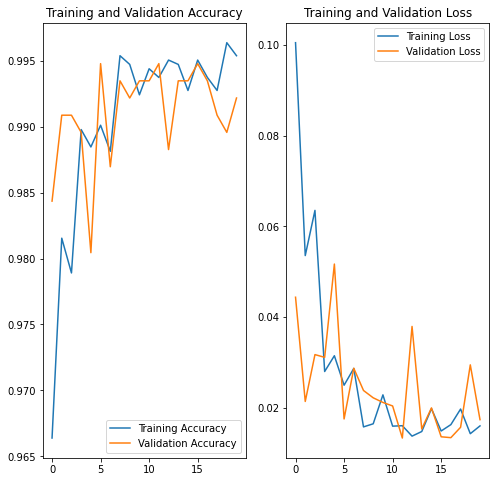

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
